# Image Clustering

This example shows how SentenceTransformer can be used for Image Clustering.

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

We encode all images into vector space and then find high density regions in this vector space, i.e., regions where the images are fairly similar.

In [1]:
%pip install pillow tqdm sentence-transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

/Users/lprone/Documents/test/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')


/Users/lprone/Documents/test/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

In [5]:
# Now, we need to compute the embeddings
# To speed things up, we distribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)


Images: 24996


In [6]:
# We have implemented our own, efficient method
# to find high density regions in vector space
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [7]:
# Now we run the clustering algorithm
# With the threshold parameter, we define at which threshold we identify
# two images as similar. Set the threshold lower, and you will get larger clusters which have 
# less similar images in it (e.g. black cat images vs. cat images vs. animal images).
# With min_community_size, we define that we only want to have clusters of a certain minimal size
clusters = community_detection(img_emb, threshold=0.9, min_community_size=10)
print("Total number of clusters:", len(clusters))

Total number of clusters: 147




Cluster size: 482


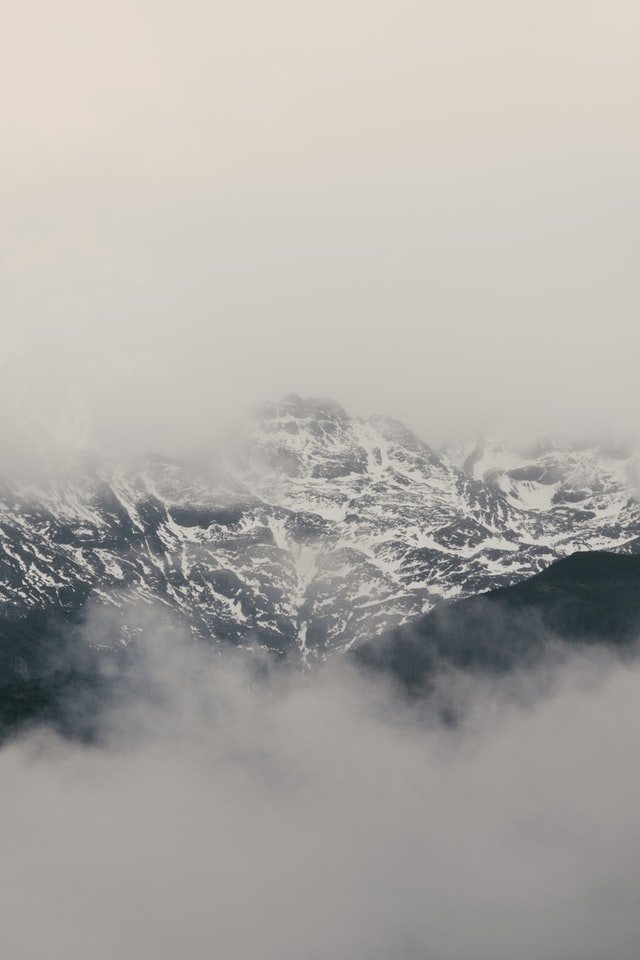

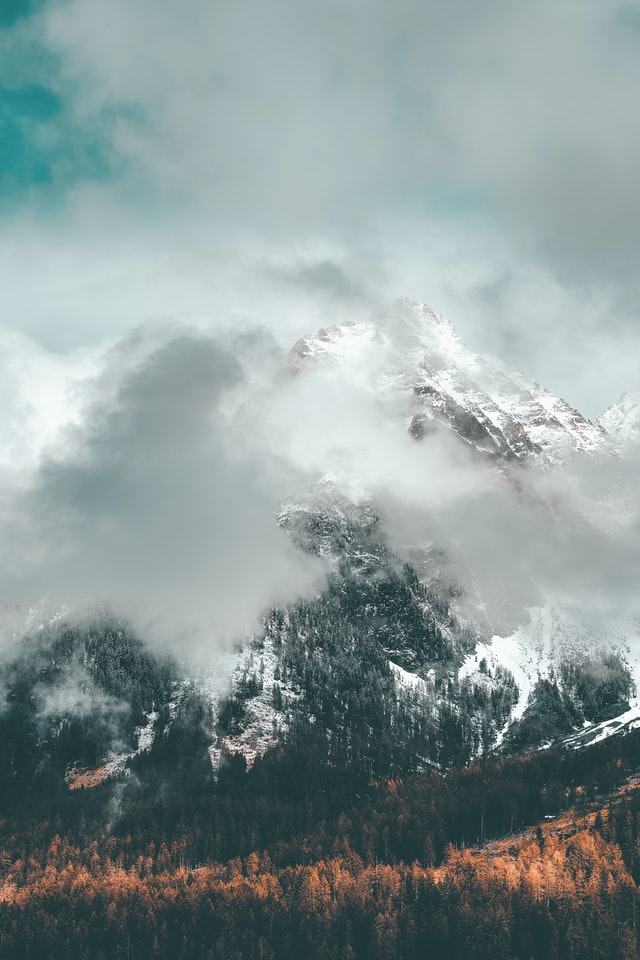

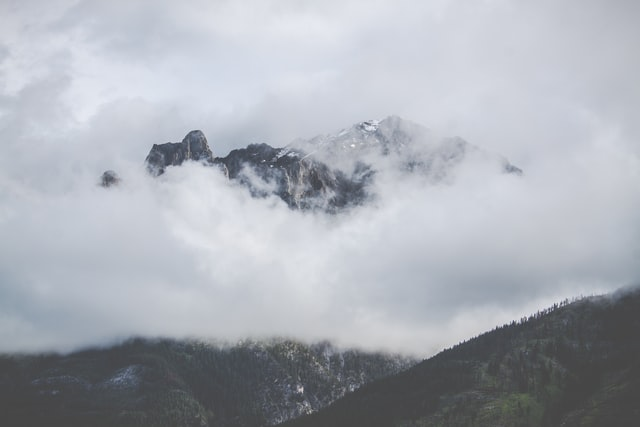



Cluster size: 401


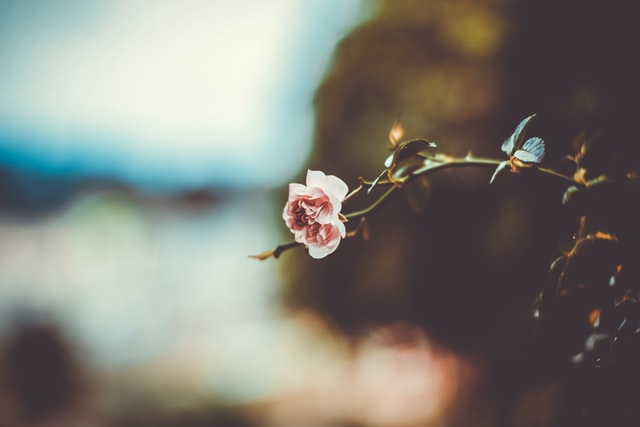

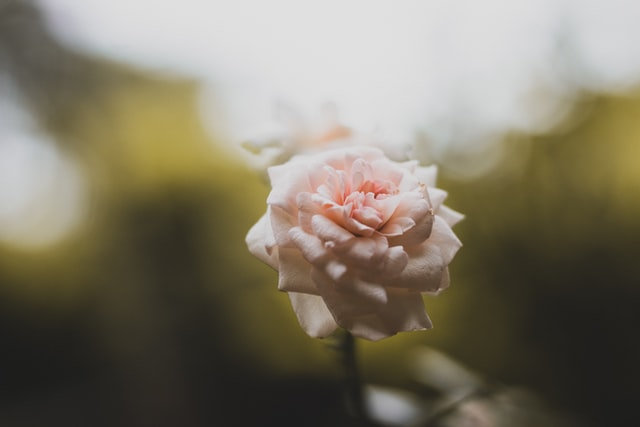

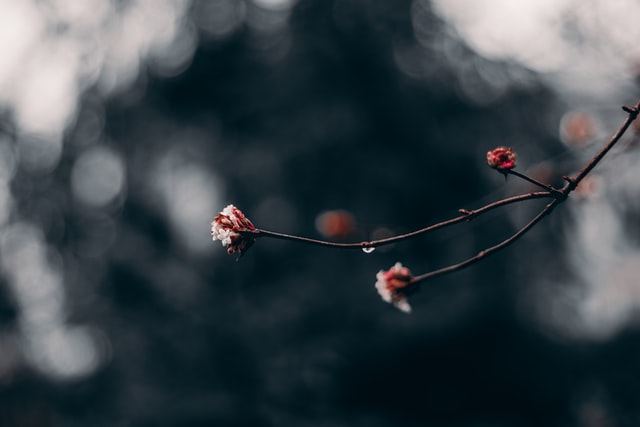



Cluster size: 360


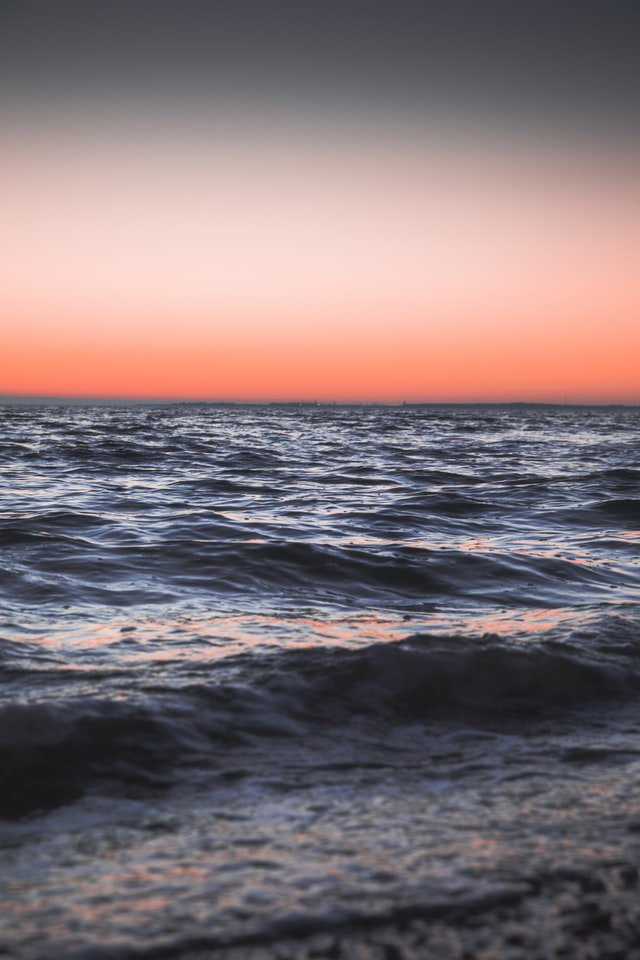

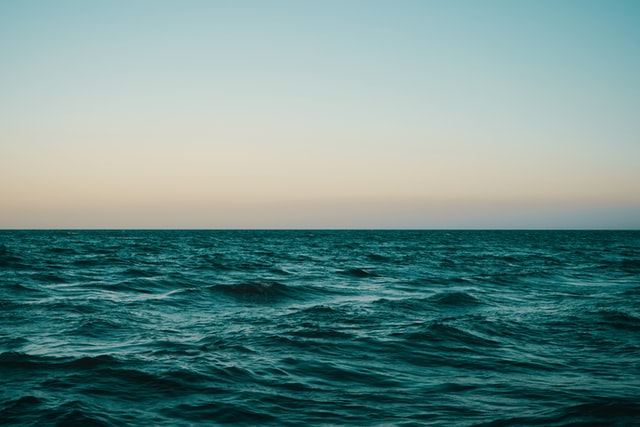

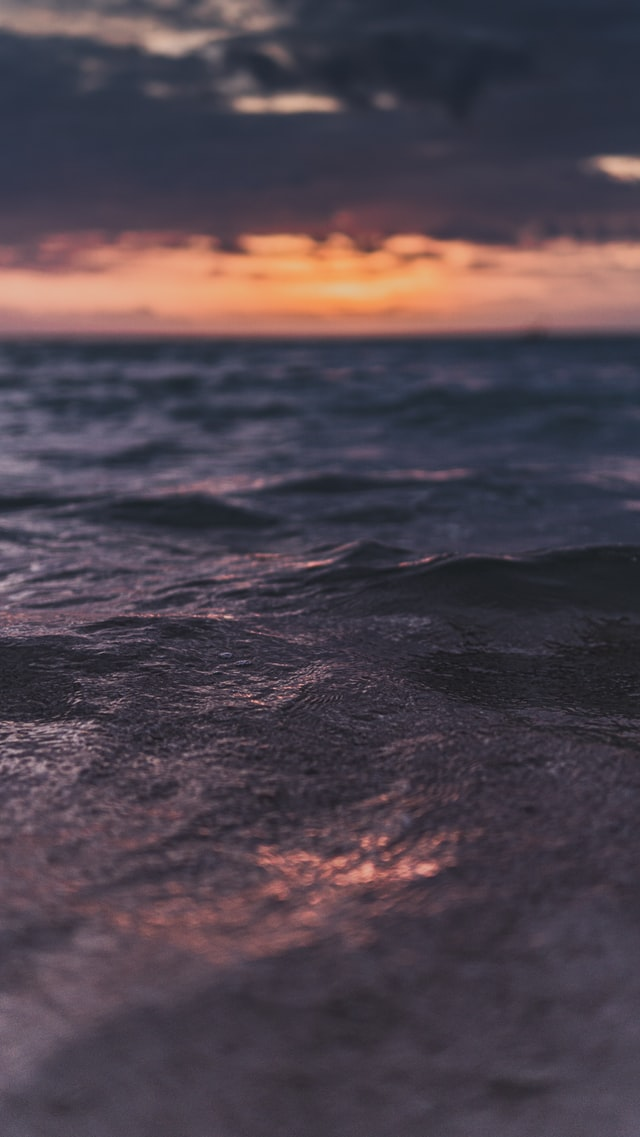



Cluster size: 258


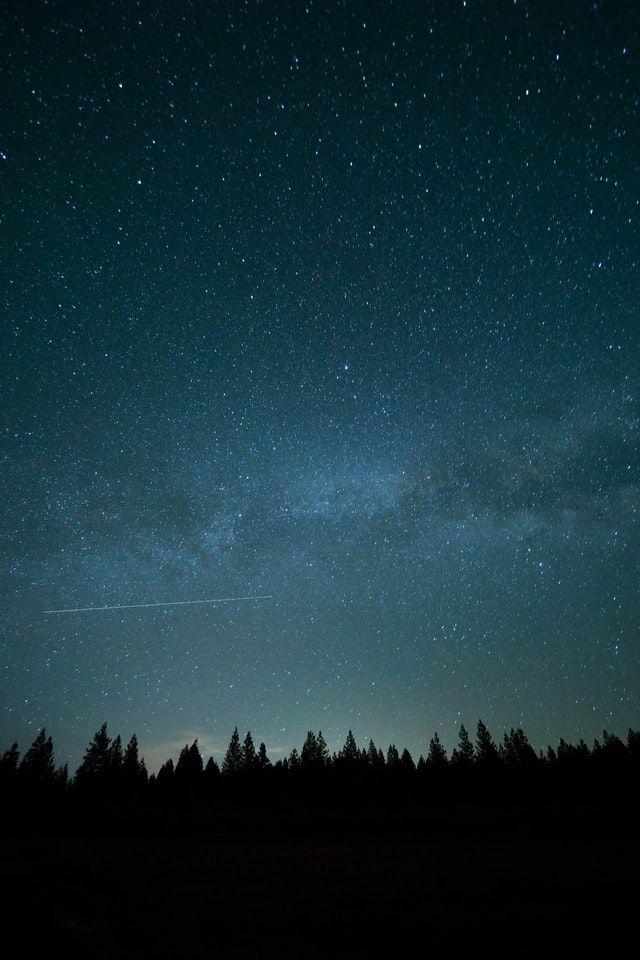

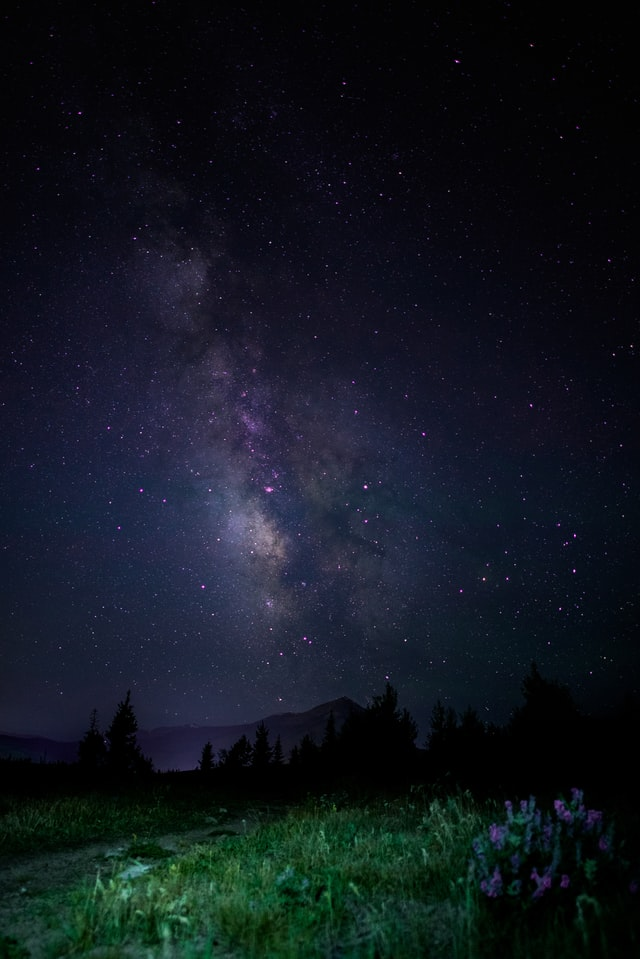

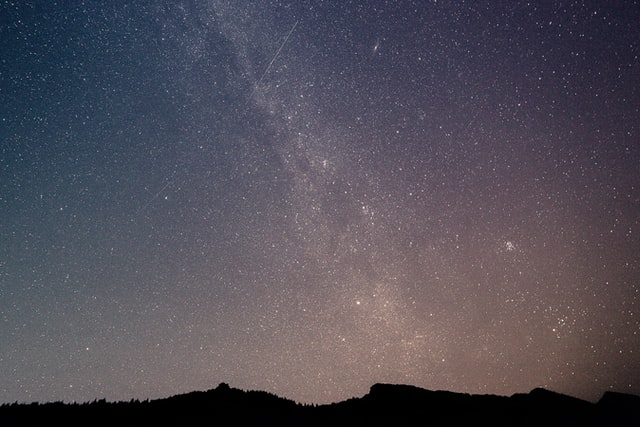



Cluster size: 194


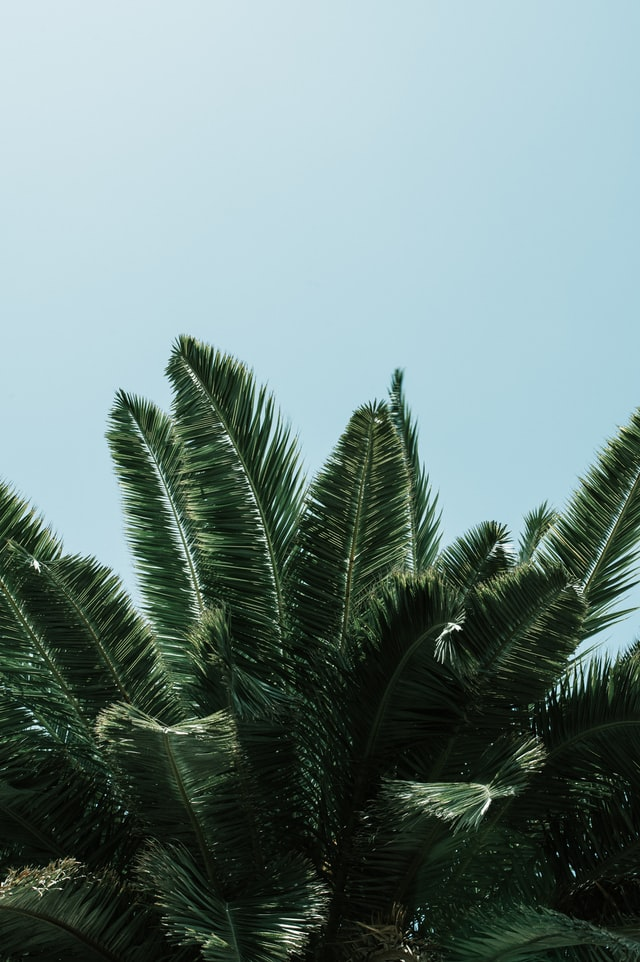

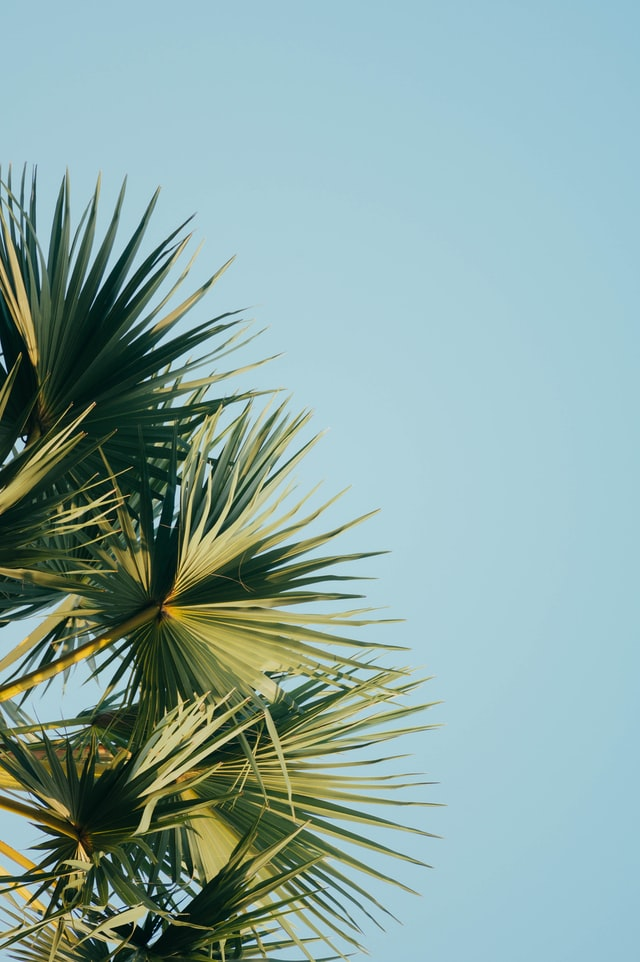

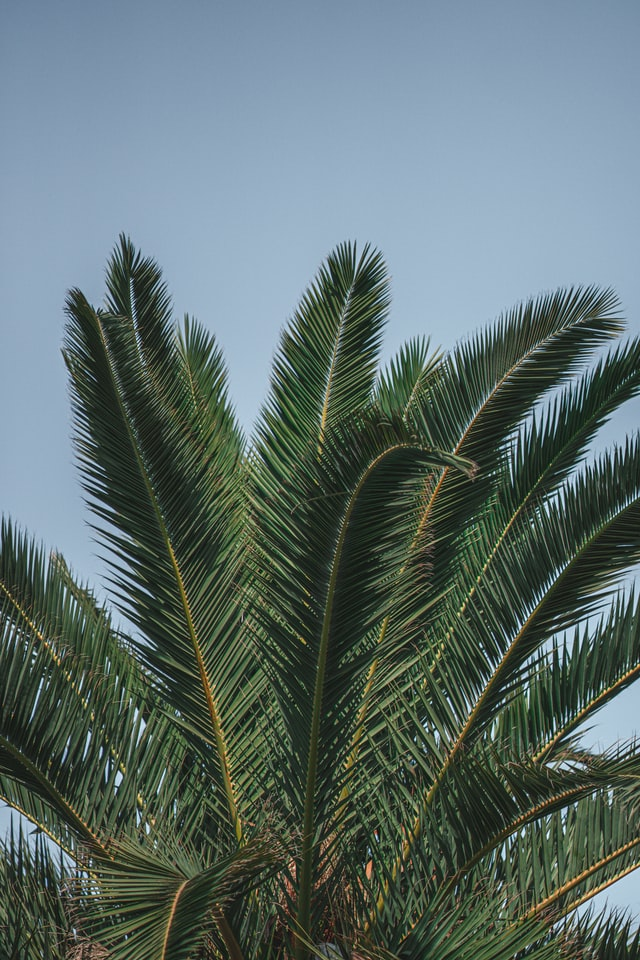



Cluster size: 145


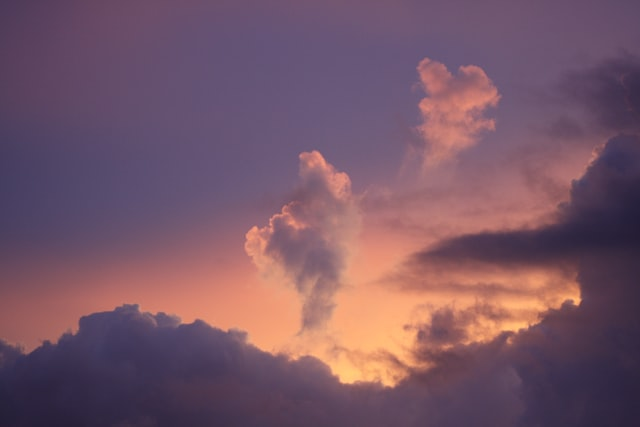

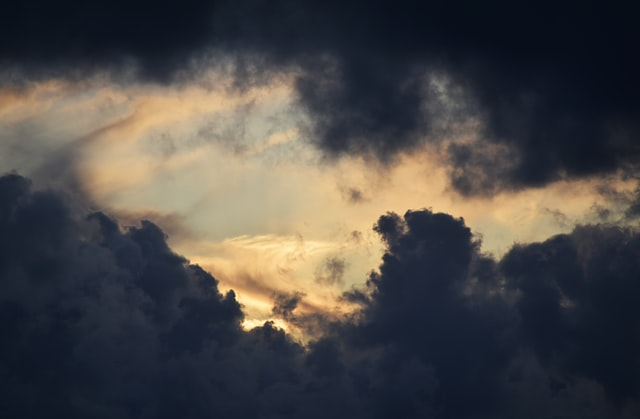

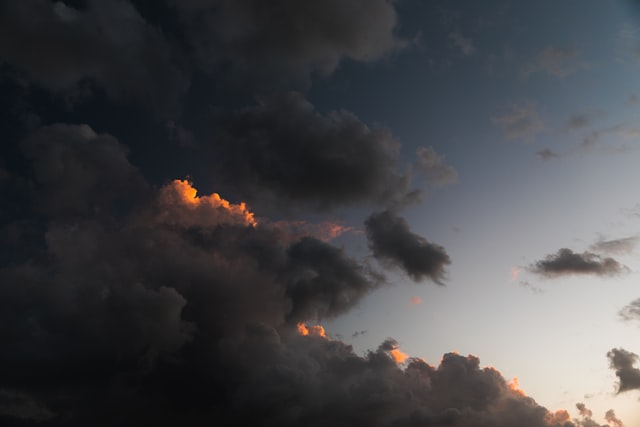



Cluster size: 117


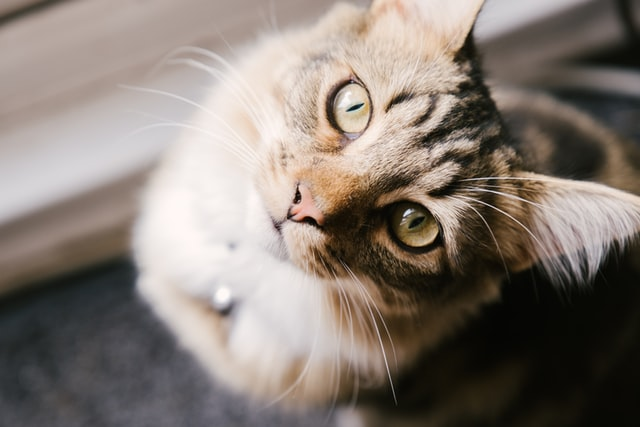

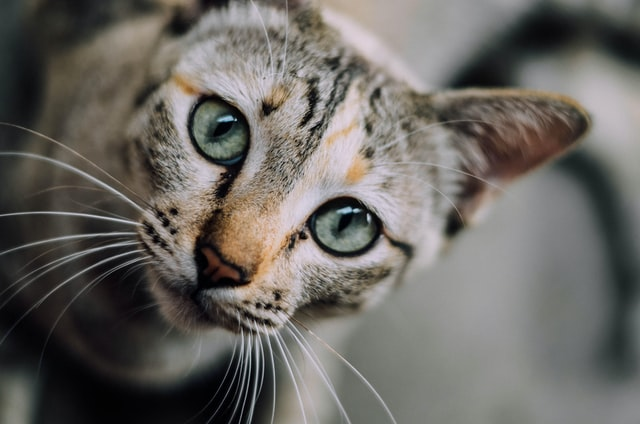

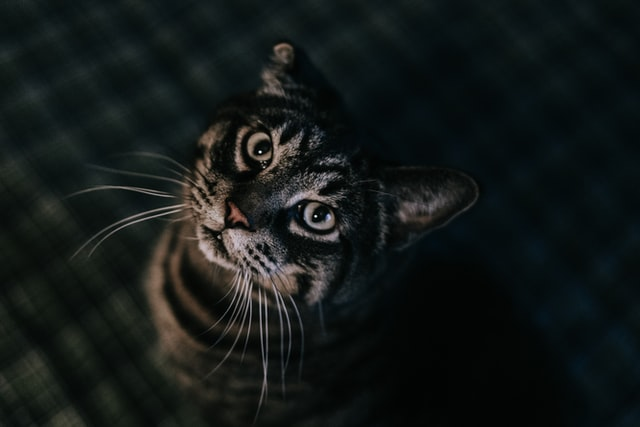



Cluster size: 113


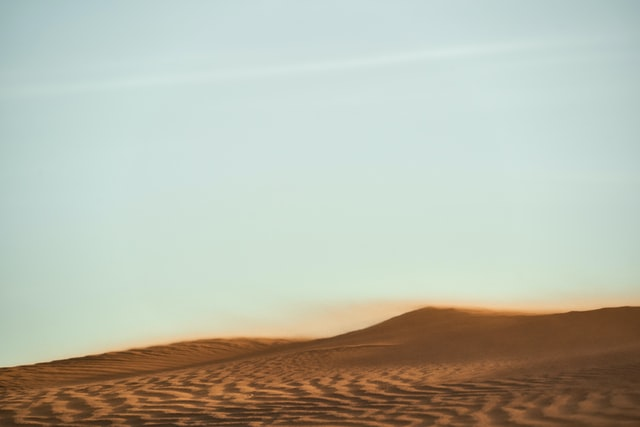

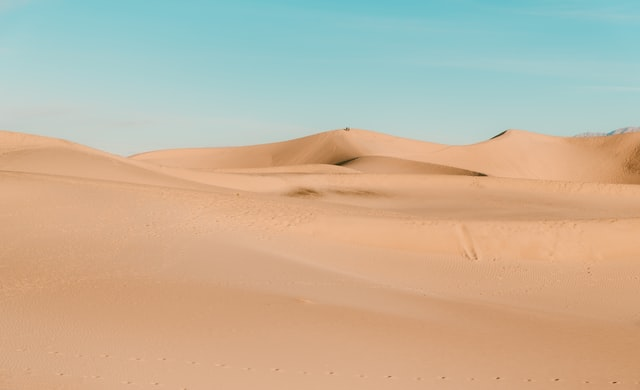

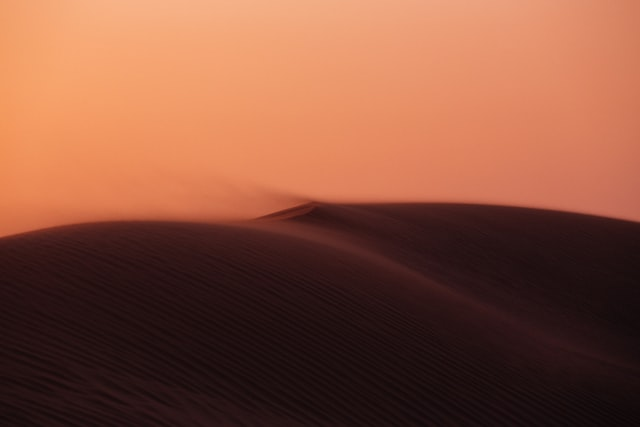



Cluster size: 101


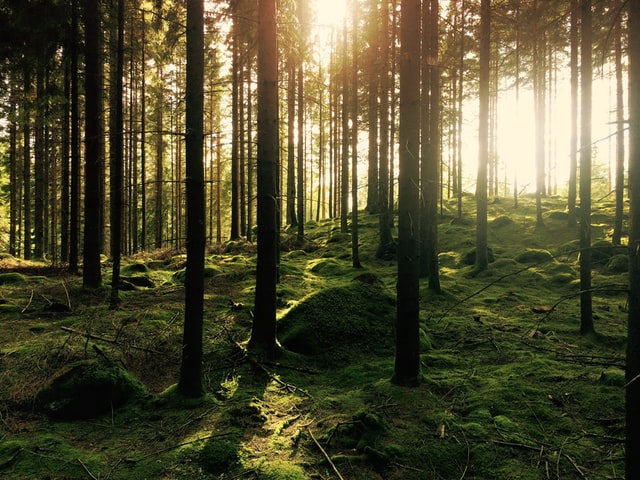

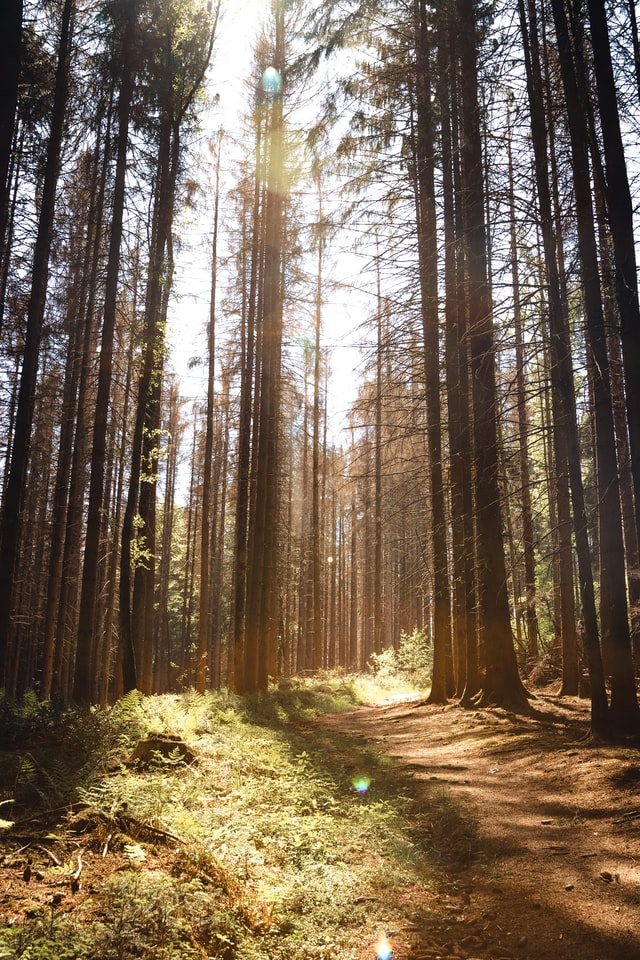

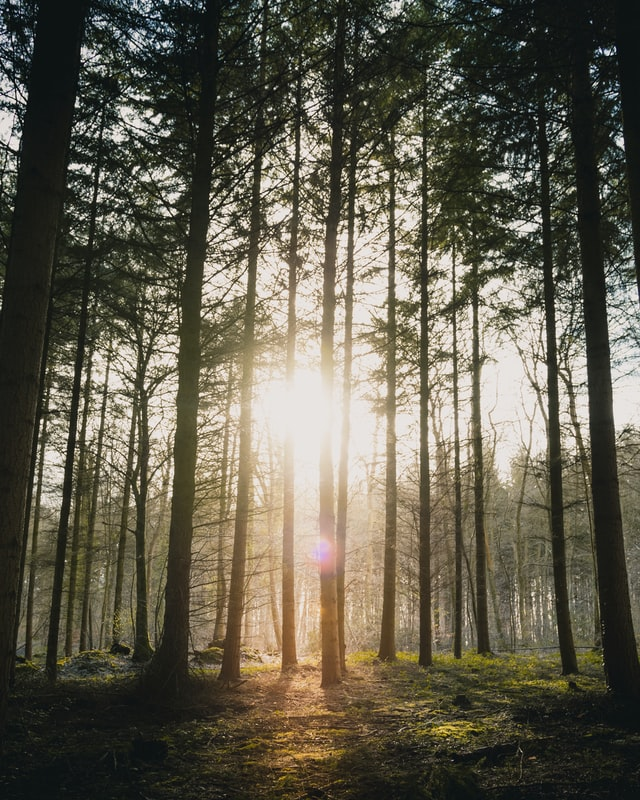



Cluster size: 97


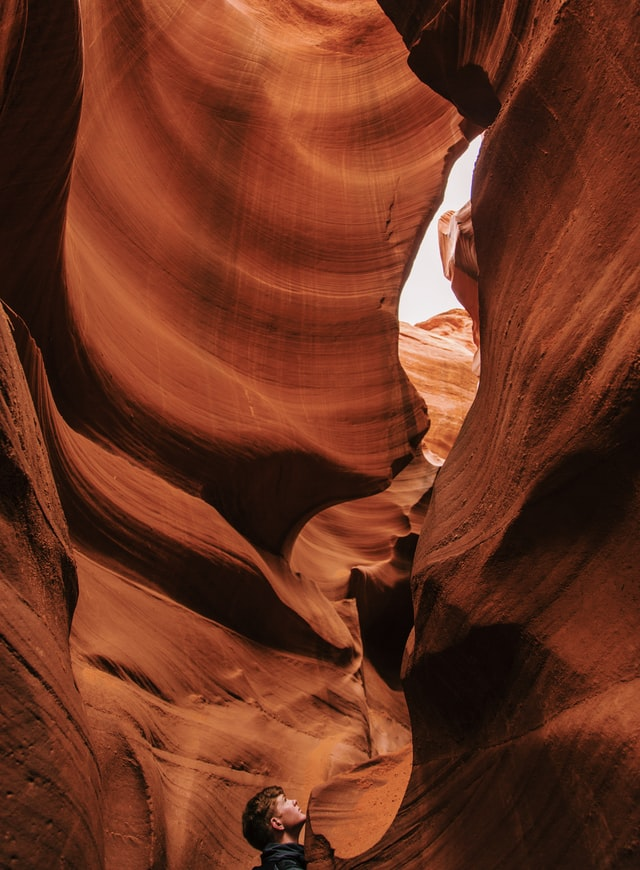

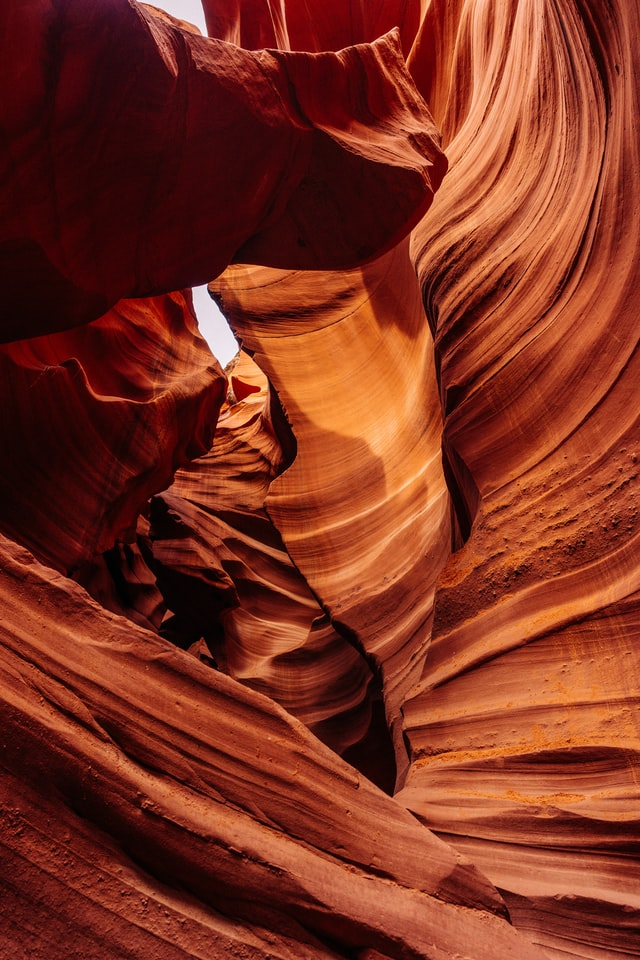

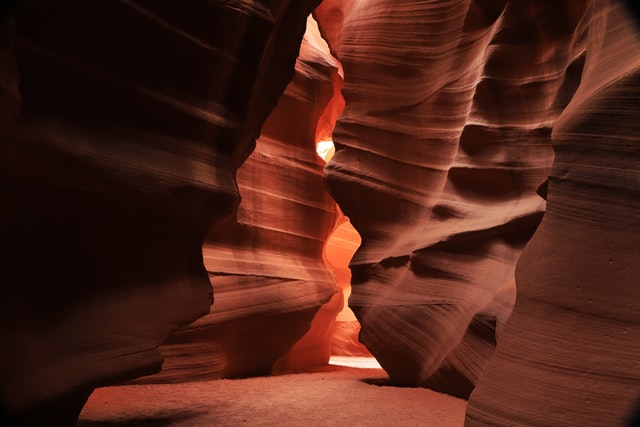

In [8]:
# Now we output the first 10 (largest) clusters
for cluster in clusters[0:10]:
    print("\n\nCluster size:", len(cluster))
    
    #Output 3 images
    for idx in cluster[0:3]:
        display(IPImage(os.path.join(img_folder, img_names[idx]), width=200))
